## Pipeline to create the personalized Boolean Networks, MaBoSS simulation, gene signature correlation

In [1]:
# Loading the data (TCGA, cell model passport)

import pandas as pd
import os
import shutil
from functions.generate_models import generate_models_re, pre_process_re

from functions.analysis import downstream_analysis

from functions.validation_utils.validation_Breast import (
    correlate_boolean_predictions_with_gene_signatures
)

from functions.analysis_utils.stats.stats_proba import compute_stats_test_after_ko

annotations_models = pd.read_csv('data/model_list_20250407.csv')
mutations_data = pd.read_csv('data/cellmodel_data/mutations_all_20250318.csv')
drug_data = pd.read_csv('data/drug_sensitivity.csv')
montagud_original_data_df = (
    pd.read_csv('data/montagud_models/Montagud_inter_nodes_data.csv', header=1)
    .loc[:, ['Target node', 'Interaction type', 'Source']])
nodes_montagud_synonyms = pd.read_csv('data/montagud_models/nodes_processed.csv')
rna_seq_data = pd.read_csv('data/cellmodel_data/rnaseq_merged_20250117/rnaseq_merged_20250117.csv')
cnv_data = pd.read_csv('data/cellmodel_data/cnv_summary_20250207.csv')
proteins_data = pd.read_csv('data/cellmodel_data/proteomics_all_20250211.csv')
onco_tsg_data = pd.read_csv('data/oncogenes_tsg.tsv', sep='\t')
                            

/var/folders/83/pqwsm5cn7vscbq8l3fnf30qr0000gn/T/ipykernel_90492/1435387419.py:22: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  nodes_montagud_synonyms = pd.read_csv('data/montagud_models/nodes_processed.csv')


In [2]:
import logging

logger = logging.getLogger(__name__)

In [3]:
# # ALL PIPELINE 


def main(normalization_techniques, number_patients, drugs_dict, type_models, continuous_variable, discrete_variable, generic_model_path, intervention_gene=None):

    inputs_list = ['EGF', 'FGF', 'TGFb', 'Nutrients', 'Hypoxia', 'Acidosis', 'Androgen', 'TNFalpha', 'SPOP', 'Carcinogen']
    phenotype_interest = ["Proliferation","Invasion","DNA_Repair","Apoptosis"]


    folder_name = f'{discrete_variable}_{continuous_variable}'



    for drug in drugs_dict:
        drug_targets = drugs_dict[drug]

        for type_model in type_models:
            for norm_technique in normalization_techniques:
                if intervention_gene is not None:
                    subdir = f"{'_'.join(drug_targets)}_target_{norm_technique}/intervention_{'_'.join(intervention_gene)}"
                else: 
                    subdir = f"{'_'.join(drug_targets)}_target_{norm_technique}"


                folder_generic_models = f"analysis/{drug}/{folder_name}/{subdir}/models/generic/"
                folder_models = f"analysis/{drug}/{folder_name}/{subdir}/models"
                folder_results = f"analysis/{drug}/{folder_name}/{subdir}"


                patients_categ = ['resistant', 'sensitive', 'healthy']
                

                for patient_categ in patients_categ:
                    os.makedirs(f"analysis/{drug}/{folder_name}/{subdir}/results/{patient_categ}", exist_ok=True)
                    os.makedirs(f"analysis/{drug}/{folder_name}/{subdir}/models/{patient_categ}", exist_ok=True)

                dest_dir = f"analysis/{drug}/{folder_name}/{subdir}/models/generic"

                os.makedirs(dest_dir, exist_ok=True)

                # Copy the files
                shutil.copy(f'{generic_model_path}.bnd', dest_dir)
                shutil.copy(f'{generic_model_path}.cfg', dest_dir)


                top_resistant_ids, top_sensitive_ids, top_healthy_ids, montagud_node_model, all_montagud_nodes, rna_seq_data_models_filtered, cnv_data_filtered, df_melted_protein, mutations_data_filtered = pre_process_re(
                montagud_original_data_df.copy(),
                nodes_montagud_synonyms,
                rna_seq_data.copy(),
                cnv_data.copy(),
                mutations_data.copy(),
                number_patients,
                drug_data.copy(),
                annotations_models.copy(),
                drug,
                proteins_data.copy(),
                type_model,
                onco_tsg_data,
                tissue_interest=None,
                tissue_remove=None,
            )
                
                patients_ids = top_resistant_ids + top_sensitive_ids + top_healthy_ids


                os.makedirs(f"analysis/{drug}/{folder_name}/{subdir}/data_filtered", exist_ok=True)
                rna_seq_data_models_filtered.to_csv(f"analysis/{drug}/{folder_name}/{subdir}/data_filtered/rna_seq_data_filtered.csv")
                cnv_data_filtered.to_csv(f"analysis/{drug}/{folder_name}/{subdir}/data_filtered/cnv_data_filtered.csv")

                # Convert list to DataFrame then save
                all_montagud_nodes_df = pd.DataFrame(all_montagud_nodes, columns=['gene_symbol'])
                all_montagud_nodes_df.to_csv(f"analysis/{drug}/{folder_name}/{subdir}/data_filtered/all_montagud_nodes.csv", index=False)

                generate_models_re(
                norm_technique,
                discrete_variable,
                continuous_variable,
                folder_generic_models,
                folder_models,
                top_resistant_ids,
                top_sensitive_ids,
                top_healthy_ids,
                drug,
                drug_targets,
                phenotype_interest,
                rna_seq_data_models_filtered,
                montagud_node_model,
                cnv_data_filtered,
                mutations_data_filtered,
                type_model,
                df_melted_protein,
                amplif_factor = 100, 
                intervention_gene = intervention_gene,  
                genetic_intervention = 'KO',
            )

                downstream_analysis(
                folder_name, 
                subdir,
                folder_results,
                folder_models,
                drug,
                top_resistant_ids,
                top_sensitive_ids,
                top_healthy_ids,
                patients_categ,
                inputs_list,
                phenotype_interest,
                annotations_models,
                intervention_gene=intervention_gene, # instead of None
                list_active_inputs=None,
            )

                proba_phenotype = pd.read_csv(f'analysis/{drug}/{folder_name}/{subdir}/results/sensitive_resistant_results/patients_phenot_table.csv', index_col=0)

                results_corr_invasion_df, correlation_invasion_data = correlate_boolean_predictions_with_gene_signatures(False, proba_phenotype, 'Epithelial Mesenchymal Transition', 'Invasion', rna_seq_data, patients_ids)
                results_corr_prolif_df, correlation_prolif_data = correlate_boolean_predictions_with_gene_signatures(False, proba_phenotype, 'G2-M Checkpoint', 'Proliferation', rna_seq_data, patients_ids)
                results_corr_apoptosis_df, correlation_prolif_data = correlate_boolean_predictions_with_gene_signatures(False, proba_phenotype, 'Apoptosis', 'Apoptosis', rna_seq_data, patients_ids)


                results_corr_invasion_df.to_csv(f'analysis/{drug}/{folder_name}/{subdir}/results/output/results_corr_invasion_df.csv')
                results_corr_prolif_df.to_csv(f'analysis/{drug}/{folder_name}/{subdir}/results/output/results_corr_prolif_df.csv')
                results_corr_apoptosis_df.to_csv(f'analysis/{drug}/{folder_name}/{subdir}/results/output/results_corr_apoptosis_df.csv')

                
                if intervention_gene is not None:
                    res_values = pd.read_csv(
                    f'analysis/{drug}/{discrete_variable}_{continuous_variable}/'
                    f"{'_'.join(drug_targets)}_target_{norm_technique}/results/resistant/combined_results.csv",
                    index_col=0
                )   
                    sens_values = pd.read_csv(
                    f'analysis/{drug}/{discrete_variable}_{continuous_variable}/'
                    f"{'_'.join(drug_targets)}_target_{norm_technique}/results/sensitive/combined_results.csv",
                    index_col=0
                )
                    


                    # after KO
                    res_values_knockout_ctnnb1 = pd.read_csv(
                    f'analysis/{drug}/{discrete_variable}_{continuous_variable}/{subdir}/results/resistant/combined_results.csv',
                    index_col=0
                )
                    sens_values_knockout_ctnnb1 = pd.read_csv(
                    f'analysis/{drug}/{discrete_variable}_{continuous_variable}/{subdir}/results/sensitive/combined_results.csv',
                    index_col=0
                    )

                    output_folder = f'analysis/{drug}/{discrete_variable}_{continuous_variable}/{subdir}/results/output'



                    compute_stats_test_after_ko(res_values,  sens_values, res_values_knockout_ctnnb1, sens_values_knockout_ctnnb1 , output_folder, 'EGF','Invasion')
                    

                logger.debug(f"Completed {drug} with {norm_technique} normalization successfully!")

    logger.debug("Pipeline completed!")

None


/Users/romane/repos/icr/Attractor-Resistance/functions/generate_utils/identification_patients/get_patients_sens_res.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotations_models_filtered.rename(


All .cfg and .bnd files created for sensitive, resistant and healthy patients.


/Users/romane/repos/icr/Attractor-Resistance/functions/generate_utils/pre_process_data/pre_process_genes.py:191: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_zero_inflation[results_zero_inflation['is_zero_inflated'].fillna(False) == True].index
no genes with zero distribution
/Users/romane/repos/icr/Attractor-Resistance/functions/generate_utils/pre_process_data/pre_process_genes.py:191: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_zero_inflation[results_zero_inflation['is_zero_inflated'].fillna(False) == True].index
no genes with zero d

KeyboardInterrupt: 

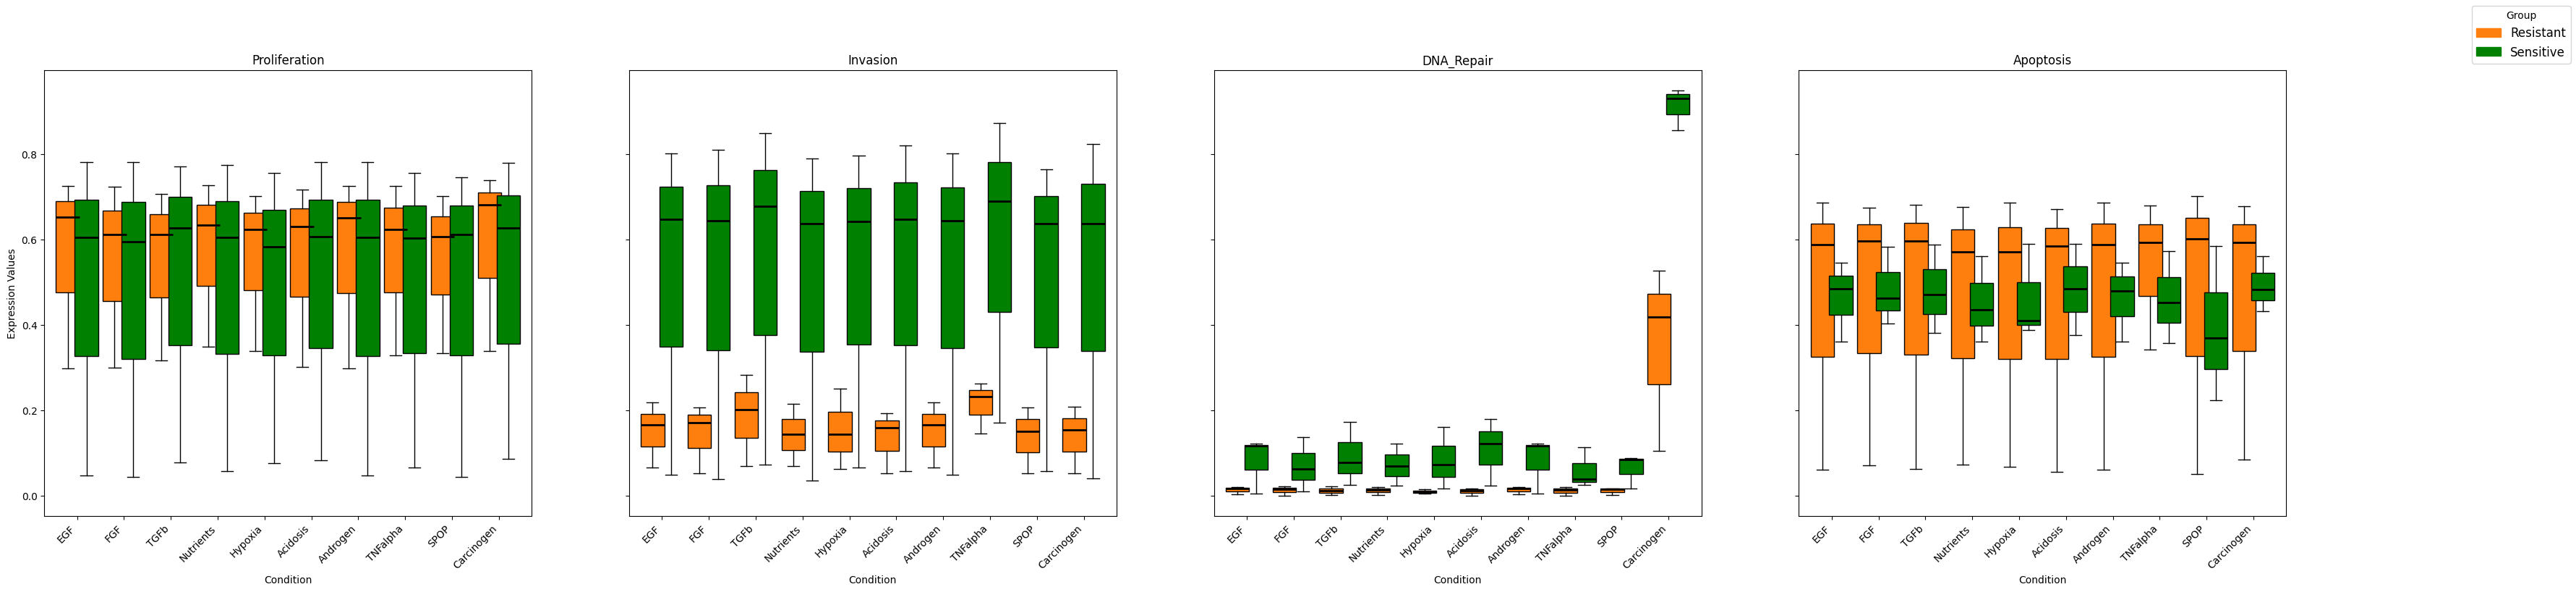

In [5]:
drugs_dict = {'Refametinib': ['MEK1_2']}


type_models = ['genes_models']

continuous_variable = 'genes'
discrete_variable = 'mutations'

# normalization_techniques = ['sigmoid', 'min-max','log_transf','global_minmax', 'global_log']

normalization_techniques = ['distribution_normalization']


number_patients = 3
# intervention_gene = ['beta_catenin', 'CyclinD']
# intervention_gene = None
generic_model_path = 'data/montagud_models/Montagud2022_Prostate_Cancer'



interventions = [None, ['beta_catenin', 'CyclinD']]
for interv in interventions:
    print(interv)
    main(normalization_techniques, number_patients, drugs_dict, type_models, continuous_variable, discrete_variable, generic_model_path, intervention_gene = interv)


first run the pipeline without intervention gene and then run again with intervention gene 


-> appeler la fonction deux fois 
-> stats sur les resultat 